In [1]:
!pip3 install vaderSentiment

In [2]:
!pip3 install torch
!pip3 install transformers

In [3]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline,FeatureUnion
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import plot_roc_curve
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from nltk.cluster import KMeansClusterer,cosine_distance, euclidean_distance
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping,CSVLogger

import torch
import transformers as ppb # pytorch transformers

In [4]:
!pip3 install spacy-transformers

In [5]:
!python3 -m spacy download en_trf_bertbaseuncased_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_trf_bertbaseuncased_lg')


In [6]:
import spacy
import pandas as pd

In [7]:
nlp=spacy.load('/usr/local/lib/python3.6/dist-packages/en_trf_bertbaseuncased_lg/en_trf_bertbaseuncased_lg-2.3.0')

Let's test it to see if it's working well.

In [8]:
apple1 = nlp("Apple shares rose on the news.")
apple2 = nlp("Apple sold fewer iPhones this quarter.")
apple3 = nlp("Apple pie is delicious.")
print(apple1[0].similarity(apple2[0]))  # 0.73428553
print(apple1[0].similarity(apple3[0]))  # 0.43365782

0.73428565
0.43365785


In [9]:
reviews_ratings=pd.read_csv('/content/drive/My Drive/amazon_reviews_project/reviews_and_ratings.csv')

In [10]:
reviews_ratings.head(2)

,overall,reviewText
0,1,I was a huge fan when the Divergent series sta...
1,4,Excellent read.


In [11]:
reviews_ratings.shape

(5535445, 2)

In [12]:
#Let's just take the first 10_000 rows to test for feasibility.
reviews_ratings_selection=reviews_ratings.loc[:3_000]

In [13]:
#reviews_ratings_selection.dropna(inplace=True)

In [14]:
del reviews_ratings
gc.collect()

20

In [15]:
#parameters for tokenization
max_len=300
training_samples=2_500
validation_samples=500
max_words=1_000

In [16]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [17]:
#instantiate the tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [18]:
text_data=reviews_ratings_selection['reviewText'].astype('str')

In [19]:
#instantiate instance of Vader sentiment analyzer
sentiment=SentimentIntensityAnalyzer()
#using vader sentiment analyzer for a second input
df=pd.DataFrame(text_data)
#df['polarity']=sentiment.polarity_scores(df['reviewText'][:200])
df_polarity=pd.DataFrame([sentiment.polarity_scores(df.loc[:,'reviewText'][i][-200:]) for i in range(len(df))])

In [20]:
df_polarity_input=df_polarity.iloc[:,:3]

In [21]:
#tokenized = df.loc[:,'reviewText'][i][:200].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
df_to_tokenize=pd.DataFrame([df.loc[:,'reviewText'][i][:200] for i in range(len(df))])
df_to_tokenize

,0
0,I was a huge fan when the Divergent series sta...
1,Excellent read.
2,From the very beginning.. I have loved Odd Tho...
3,"A good, easy, light-hearted read--however ther..."
4,"As a fan of Daniel Silva's books, especially ..."
...,...
2996,I lost 25lbs in 8 weeks. I can't say enough ab...
2997,Interesting and not predictable. It's a good r...
2998,A spirited adventure story woven around actual...
2999,I ordered the Fagle translation to download an...


In [22]:
tokenized = df_to_tokenize[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))


In [23]:
#padding
#max_len = 0
#for i in tokenized.values:
#    if len(i) > max_len:
#        max_len = len(i)

#padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [24]:
#fit the tokenizer
#tokenizer.fit_on_texts(text_data)

In [25]:
#create the sequences
#sequences=tokenizer.texts_to_sequences(text_data)
#sequences=tokenizer.texts_to_sequences(tokenized)

In [26]:
#pad sequences
#padded_data=pad_sequences(tokenized,maxlen=max_len) #to be able to handle docs too small to feed.

In [27]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded_data = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [28]:
padded_data.shape

(3001, 97)

In [29]:
attention_mask = np.where(padded_data != 0, 1, 0)
attention_mask.shape

(3001, 97)

In [30]:
type(padded_data)

numpy.ndarray

In [31]:
input_ids = torch.tensor(padded_data)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask)

In [32]:
data = last_hidden_states[0][:,0,:].numpy()

In [33]:
data.shape

(3001, 768)

In [34]:
#y is rating (here referred to as 'overall')
y=reviews_ratings_selection['overall']

In [35]:
#create train/test sets
X_train=data[:training_samples]
df_polarity_train=df_polarity_input[:training_samples]
X_test=data[training_samples:training_samples+validation_samples]
df_polarity_test=df_polarity_input[training_samples:training_samples+validation_samples]

y_train=y[:training_samples]
y_train_categorical=tf.keras.utils.to_categorical(y_train)[:,1:]  #dropping first column
y_train_categorical[:4]
y_test=y[training_samples:training_samples+validation_samples]
y_test_categorical=tf.keras.utils.to_categorical(y_test)[:,1:]  #dropping first column
y_test_categorical[:100]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0.

In [36]:
y_test[90:100]

2590    3
2591    2
2592    5
2593    3
2594    5
2595    5
2596    4
2597    3
2598    3
2599    1
Name: overall, dtype: int64

In [37]:
df_polarity_input

,neg,neu,pos
0,0.190,0.694,0.116
1,0.000,0.213,0.787
2,0.058,0.733,0.209
3,0.000,0.784,0.216
4,0.060,0.802,0.138
...,...,...,...
2996,0.099,0.737,0.164
2997,0.204,0.468,0.328
2998,0.069,0.893,0.037
2999,0.148,0.677,0.174


Thus, ratings 1,2,3,4,5 correspond to labels 0,1,2,3,4 respectively.

In [38]:
#simple network model
#model=Sequential()
#model.add(Dense(64,activation='relu'))
#model.add(Dense(1,activation='linear'))

In [39]:
input_A = keras.layers.Input(shape=(768, ))
input_B = keras.layers.Input(shape=(3, ))
batch_normalization=keras.layers.BatchNormalization()(input_A)
hidden1=keras.layers.Dense(400,activation='relu',kernel_regularizer=l2(0))(batch_normalization)
hidden2=keras.layers.Dense(3200,activation='relu',kernel_regularizer=l2(0))(hidden1)
hidden3=keras.layers.Dense(6400,activation='relu',kernel_regularizer=l2(0))(hidden2)
hidden4=keras.layers.Dense(1600,activation='relu',kernel_regularizer=l2(0))(hidden3)
hidden5=keras.layers.Dense(400,activation='relu',kernel_regularizer=l2(0))(hidden4)
hidden6=keras.layers.Dense(200,activation='relu',kernel_regularizer=l2(0))(hidden5)
hidden7=keras.layers.Dense(200,activation='relu',kernel_regularizer=l2(0))(hidden6)
hidden8=keras.layers.Dense(100,activation='relu',kernel_regularizer=l2(0))(hidden7)
hidden9=keras.layers.Dense(100,activation='relu',kernel_regularizer=l2(0))(hidden8)
hidden10=keras.layers.Dense(50,activation='relu',kernel_regularizer=l2(0))(hidden9)
hidden11=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(0))(hidden10)
concat=keras.layers.concatenate([hidden1,hidden2,hidden3,hidden4,hidden5,hidden11])
hidden12=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(100))(concat)
concat2=keras.layers.concatenate([hidden12,input_B])
batch_normalization2=keras.layers.BatchNormalization()(concat2)
hidden13=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(10))(batch_normalization2)
hidden14=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(0))(hidden13)
hidden15=keras.layers.Dense(50,activation='relu',kernel_regularizer=l2(0))(hidden14)
hidden16=keras.layers.Dense(25,activation='relu',kernel_regularizer=l2(10))(hidden15)
output=keras.layers.Dense(5,activation='softmax')(hidden15)

model=keras.models.Model(inputs=[input_A,input_B], outputs=[output])

In [40]:
#add a callback
callback=EarlyStopping(monitor='loss',patience=5)

In [41]:
#compile
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=0.001), #'Adadelta',  #keras.optimizers.Adam(lr=0.00001),
    metrics=['accuracy'],
)

In [42]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768)          3072        input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 400)          307600      batch_normalization[0][0]        
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3200)         1283200     dense[0][0]                      
_______________________________________________________________________________________

In [43]:
#Let's perform value_count on reviews_ratings_selection by 'overall'. This will help us compute appropriate class weights for each class.
reviews_ratings_selection['overall'].value_counts(normalize=True)

5    0.668777
4    0.172276
3    0.076974
1    0.044985
2    0.036988
Name: overall, dtype: float64

In [44]:
class_weight = {4: 1,
                3: 10,
                2: 10,
                0: 20,
                1: 20}

#4: 2.5, 3: 4, 2: 3, 0: 3, 1: 1

In [63]:
#fit
history=model.fit((X_train,df_polarity_train),y_train_categorical,batch_size=32,class_weight=class_weight,validation_data=((X_test,df_polarity_test),y_test_categorical),epochs=200,verbose=1)

Epoch 1/200
79/79 [==============================] - 8s 98ms/step - loss: 9.2269 - accuracy: 0.8556 - val_loss: 14.6482 - val_accuracy: 0.4440
Epoch 2/200
79/79 [==============================] - 8s 95ms/step - loss: 9.2654 - accuracy: 0.8444 - val_loss: 12.3115 - val_accuracy: 0.4160
Epoch 3/200
79/79 [==============================] - 7s 95ms/step - loss: 9.2257 - accuracy: 0.8460 - val_loss: 19.7877 - val_accuracy: 0.1800
Epoch 4/200
79/79 [==============================] - 8s 95ms/step - loss: 9.1251 - accuracy: 0.8364 - val_loss: 15.6362 - val_accuracy: 0.1380
Epoch 5/200
79/79 [==============================] - 8s 96ms/step - loss: 9.4859 - accuracy: 0.8332 - val_loss: 11.6151 - val_accuracy: 0.5660
Epoch 6/200
79/79 [==============================] - 8s 97ms/step - loss: 9.2175 - accuracy: 0.8216 - val_loss: 13.5965 - val_accuracy: 0.4440
Epoch 7/200
79/79 [==============================] - 8s 102ms/step - loss: 9.1167 - accuracy: 0.8432 - val_loss: 13.6371 - val_accuracy: 0.434

KeyboardInterrupt: ignored

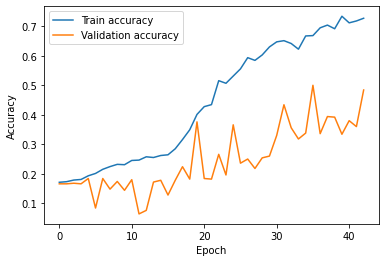

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],label='Train accuracy')   #mae on training set
plt.plot(history.history['val_accuracy'],label='Validation accuracy');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

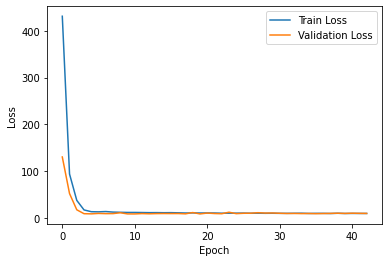

In [56]:
plt.plot(history.history['loss'],label='Train Loss')   #mae on training set
plt.plot(history.history['val_loss'],label='Validation Loss');  #mae on validation set
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

In [57]:
X_train.shape

(2500, 768)

In [58]:
model

In [59]:
preds=model.predict((X_test,df_polarity_test))

In [60]:
preds_class=np.argmax(preds,axis=1)+1

In [61]:
print(classification_report(y_test,preds_class))

              precision    recall  f1-score   support

           1       0.32      0.38      0.35        21
           2       0.00      0.00      0.00        14
           3       0.14      0.17      0.15        29
           4       0.19      0.42      0.26        83
           5       0.76      0.55      0.64       353

    accuracy                           0.48       500
   macro avg       0.28      0.30      0.28       500
weighted avg       0.59      0.48      0.52       500



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
pd.DataFrame(preds_class).value_counts()

5    255
4    183
3     37
1     25
dtype: int64

In [54]:
y_test.value_counts(normalize=True)

5    0.706
4    0.166
3    0.058
1    0.042
2    0.028
Name: overall, dtype: float64